# InsTAP

<img src="http://store-images.s-microsoft.com/image/apps.31997.13510798887167234.6cd52261-a276-49cf-9b6b-9ef8491fb799.30e70ce4-33c5-43d6-9af1-491fe4679377" alt="Drawing" style="width: 200px;" align="center" />

Il progetto **InsTAP** ha come obiettivo quello di analizzare diversi profili Instagram e valutare la positività o negatività dei commenti presenti nei vari post.

Coded by Gianluca Di Franco e Rosario Amantia

[Github Project](https://github.com/rosarioamantia/insTAP)

*Immagine del flusso del proggetti*
   

# Data Ingestion

La sorgente è ovviamente il Social Network Instagram. Per recuperare il i dati di cui avevamo bisogno, abbiamo fatto uso di un pacchetto chiamato **Instaloader**.

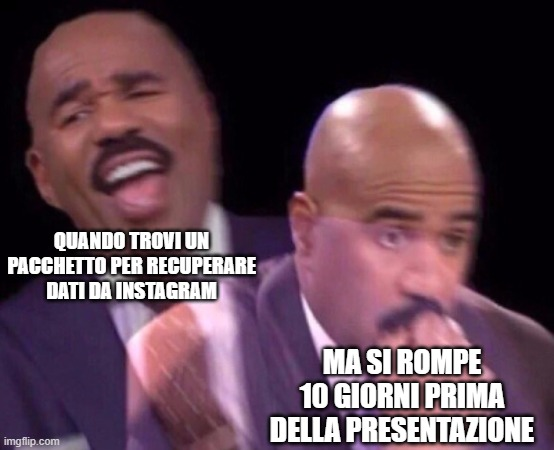

## Producer

Al fine di generare ed inviare i dati da Instagram abbiamo programmato un producer basato sul pacchetto instaloader citato in precedenza.

Il producer si occuperà di recuperare ed inviare le seguenti informazioni contenute all'interno dei post degli utenti in esame: 
- utente che crea il post
- Immagine 
- descrizione
- data di creazione
- coordinate
- commenti 

In [9]:
pip install instaloader

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\UNI\TAP\insTAP\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [8]:
import instaloader

insta = instaloader.Instaloader()
insta.login("user", "pass")
posts = instaloader.Profile.from_username(insta.context, "chiaraferragni").get_posts()

for i, post in enumerate(posts):
    if i == 3:
        break
    comments = post.get_comments()
    for index, comment in enumerate(comments):
        if index == 3:
            break

        data = {
            'id': i,
            'user': post.owner_username,
            'comment': comment.text,
            'caption': post.caption,
            'image': post.url,
            'timestamp': str(post.date_local),
            'lat': post.location.lat,
            'lng': post.location.lng
        }
        print(str(data))

KeyError: "name='csrftoken', domain=None, path=None"

## Github Streaming

<img src="img/github_meme.jpg" alt="Drawing" style="width: 800px;" align="center" />

We used Github's API to get relevant information that we used.

With API we can gain access to users and repositories.

[Example](https://api.github.com/users/josura)

## Data Parser

We used Python to create JSON files for initial part of modelling and daily data to emulate the streaming of new repositories.

<img src="img/json-bourne.jpg" alt="Drawing" style="width: 400px;" align="center" />

In [13]:
import requests

link = "https://api.github.com/repositories"
data = requests.get(link)
print(data.text)

[{"id":1,"node_id":"MDEwOlJlcG9zaXRvcnkx","name":"grit","full_name":"mojombo/grit","private":false,"owner":{"login":"mojombo","id":1,"node_id":"MDQ6VXNlcjE=","avatar_url":"https://avatars0.githubusercontent.com/u/1?v=4","gravatar_id":"","url":"https://api.github.com/users/mojombo","html_url":"https://github.com/mojombo","followers_url":"https://api.github.com/users/mojombo/followers","following_url":"https://api.github.com/users/mojombo/following{/other_user}","gists_url":"https://api.github.com/users/mojombo/gists{/gist_id}","starred_url":"https://api.github.com/users/mojombo/starred{/owner}{/repo}","subscriptions_url":"https://api.github.com/users/mojombo/subscriptions","organizations_url":"https://api.github.com/users/mojombo/orgs","repos_url":"https://api.github.com/users/mojombo/repos","events_url":"https://api.github.com/users/mojombo/events{/privacy}","received_events_url":"https://api.github.com/users/mojombo/received_events","type":"User","site_admin":false},"html_url":"https:

<img src="img/python.jpg" alt="Drawing" style="width: 400px;" align="center" />

## Data Producer

We used Go to make a Kafka Producer to send the data to Kafka.

<img src="img/golang.png" alt="Drawing" style="width: 400px;" align="center" />

### Code

```
p, err := kafka.NewProducer(&kafka.ConfigMap{"bootstrap.servers": "kafka:9092"})
	if err != nil {
		panic(err)
	}
    
p.Produce(&kafka.Message{
			TopicPartition: kafka.TopicPartition{Topic: &topic, Partition: kafka.PartitionAny},
			Value:          value, }, nil)
```

## What do we send?

```
type Repositories []struct {
	URL    string `json:"url"`
	Owner  string `json:"owner"`
	Readme string `json:"readme"`
	Stars  int    `json:"stars"`
}
```

# Data Consumer (testing)

We also used Go to make a Kafka Consumer for testing purpose.

### Code

```
c, err := kafka.NewConsumer(&kafka.ConfigMap{
		"bootstrap.servers": "kafka:9092",
		"group.id":          "consumer",
		"auto.offset.reset": "earliest",
        })

	if err != nil {
		panic(err)
	}
    
    c.SubscribeTopics([]string{"daily-repos", "^aRegex.*[Tt]opic"}, nil)
    
    for {
		msg, err := c.ReadMessage(-1)
		if err == nil {
			fmt.Printf("Message on %s: %s\n", msg.TopicPartition, string(msg.Value))
		} else {
			// The client will automatically try to recover from all errors.
			fmt.Printf("Consumer error: %v (%v)\n", err, msg)
		}
	}

	c.Close()
```

# Kafka

Kafka is the communication's interface of the platform for messages and streaming among various components.

We mainly use it for keeping messages published by the data ingestion part of the project by Go.

From the other side of the data pipeline we used Kafka to provide data in streaming and use it to construct and train the model. Also we used it for the prediction of repositories.

 # Spark

Apache Spark is an open-source distributed general-purpose cluster-computing framework.

We used Spark to create and train the model.

<img src="img/giorgio.jpg" alt="Drawing" style="width: 800px;" align="center" />

### Code Spark Init
```
val spark = SparkSession.builder.appName("Clustering and classification pipelines").
    config("es.nodes","elastic-search").config("es.index.auto.create", "true").config("es.port","9200").//config("es.nodes.wan.only", "true").
    master("local[*]").getOrCreate()
```

## Model

The model is mainly based on ensemble strategies. To build the ensemble strategy, more base models were used these models were modified and rearranged for the model's construction that will provide repositories' predictions and recommendations to the user.

As interface to Spark, we used Scala because **Apache Spark** is implemented in this language and because Scala has a concise API for users.

It let us call into other Java-based/Scala-based Big Data systems like HDFS.


First of all, a clustering model is created to assign the initial labels used for the next step(classification and recommendation). The data used are obtained in the first step of data ingestion.

### Code
```
def createPipelineKmeans(numcluster:Int):Pipeline = {
    val tokenizer = new Tokenizer().setInputCol("readme").setOutputCol("words")
    val hashingTF = new HashingTF().setNumFeatures(1000).setInputCol(tokenizer.getOutputCol).setOutputCol("features")
    val kmeans = new KMeans().setK(numcluster).setSeed(1L)
    new Pipeline().setStages(Array(tokenizer, hashingTF, kmeans))
}

[...]

val readme: Dataset[Row]=  cleanRepos(spark.read.json("data/fulldata.json"))
val pipeline = createPipelineKmeans(50)
val model = pipeline fit readme
val predictions = (model transform readme).withColumnRenamed("prediction","label")
```

After the creation of the clustering model, the classification's model is created and it will be used for the prediction of repositories' new labels.

### Code
```
def createPipelinePerceptrons(layers:Array[Int]) :Pipeline = {
    val tokenizer = new Tokenizer().setInputCol("readme").setOutputCol("words")
    val hashingTF = new HashingTF().setNumFeatures(1000).setInputCol(tokenizer.getOutputCol).setOutputCol("features")
    val trainer = new MultilayerPerceptronClassifier().setLayers(layers).setBlockSize(128).setSeed(1234L).setMaxIter(100)
    new Pipeline().setStages(Array(tokenizer, hashingTF, trainer))
  }

[...]

val pipelinePerceptron = createPipelinePerceptrons(Array(1000, 50, 50, LabelNumber))
```

## Spark Streaming

We take the data from Kafka with the use of Spark Streaming, selecting the topics that we want to stream.

After the prediction of the labels for the new repositories streamed from Kafka, the system will stream the predictions to ElasticSearch.

### Code
```
def predictNewReposLabel(oldRepos:Dataset[Row],newRepos:Dataset[Row],model:PipelineModel):Dataset[Row] = {
    val pipelineTokenizer = createPipelineTokenizer() 
    val tokenizer = pipelineTokenizer fit (oldRepos union newRepos.select("url", "owner", "readme"))
    val newReposWithFeatures = pipelineTokenizer.fit(oldRepos union newRepos.select("url", "owner", "readme")) transform newRepos
    return model transform newReposWithFeatures
  }
  
[...]

val fulldf = spark.readStream.format("kafka").option("kafka.bootstrap.servers","kafka:9092").option("subscribe","daily-repos, user-starred-repos").load()
      val repoStringDF = fulldf.selectExpr("CAST(value AS STRING)")
      val schemaRepo = new StructType().add("url",StringType).add("owner",StringType).add("readme",StringType).add("stars", IntegerType)
      val reposDaily= cleanRepos(repoStringDF.select(from_json(col("value"),schemaRepo).as("data")).select("data.*"))
      
      
      val newpredictions:Dataset[Row]=predictNewReposLabel(readme,reposDaily,bayesmodel)

      val consoleStream = newpredictions.writeStream.format("console").outputMode("append").start()
      //caricamento su elastic search
      import org.elasticsearch.spark.sql._
      import spark.implicits._

      val repositoriesTyped = newpredictions.select(col("url"),col("owner"), col("stars"),col("prediction").cast(IntegerType).as("label")).as[repositorieClassified]
      val elasticStream =repositoriesTyped.writeStream.outputMode("append").
        format("es").option("checkpointLocation","/tmp").
        option("es.mapping.id","url").start("repositories/classified").awaitTermination
```

# Elastic Search

ElasticSearch is a search engine based on the Lucene library.

We used ElasticSearch to store the classification of repositories and it is used indirectly by the web application that users interact with.

### Code
```
client, err := elastic.NewClient()
	if err != nil {
		// Handle error
		panic(err)
	}

termQuery := elastic.NewMatchQuery("owner", user)
	searchResult, err := client.Search().
		Index("repositories"). // search in index "twitter"
		Query(termQuery).      // specify the query
		From(0).Size(1000).    // take documents 0-9
		Pretty(true).          // pretty print request and response JSON
		Do(ctx)                // execute

if err != nil {
    // Handle error
    panic(err)
}
```

<img src="img/elastic.jpg" alt="Drawing" style="width: 800px;" align="center" />

# Web Application

<img src="img/beego.png" alt="Drawing" style="width: 400px;" align="center" />

We used Beego to build the web application.

Beego is a RESTful HTTP framework for the rapid development of Go applications including APIs, web apps and backend services with integrated Go specific features such as interfaces and struct embedding.

When a user create a request, the application takes the starred repositories of the user from Github and it sends them to Kafka. For this reason the web application is not very responsive 😱.

After that we make a Search Query to Elastic Search to take the suggestions.

<img src="img/web.jpg" alt="Drawing" style="width: 800px;" align="center" />

# Kibana

We make a simple Kibana Dashboard to visualize some useful information for the administrators of the platform.

<img src="img/kibana.png" alt="Drawing" style="width: 1500px;" align="center" />

# Docker

To speed up development and deployment we used Docker Containers. 

<img src="img/docker.jpg" alt="Drawing" style="width: 800px;" align="center" />

We also used Docker Compose for defining, managing links and dependencies among multiple containers with a docker-compose.yml file. 

<img src="img/docker_spark.jpg" alt="Drawing" style="width: 800px;" align="center" />

# Future outlooks

- Github Streaming of new repositories.
- Use and definition of IDs for repositories and users.
- Collaborative filtering with explicit reviews.
- Implicit reviews with Twitter API.
- HDFS to store raw data and logs.
- Security for most of the components in the project.
- Improving the performance and control over the code.
- Move to Spark 3.0 and use new functionalities.

# Problems

<img src="img/token.jpg" alt="Drawing" style="width: 800px;" align="center" />

<img src="img/giap.jpg" alt="Drawing" style="width: 800px;" align="center" />

<img src="img/github_meme3.jpg" alt="Drawing" style="width: 800px;" align="center" />

<img src="img/go_meme.jpg" alt="Drawing" style="width: 800px;" align="center" />

<img src="img/dependencies.jpg" alt="Drawing" style="width: 800px;" align="center" />